# 1. Dataset Construction

In [ ]:
import pandas as pd
# Load the data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

#Remove the specified columns
columns_to_remove = ['MonthlyCharges', 'OnlineSecurity', 'StreamingTV', 'InternetService', 'Partner']
df = df.drop(columns=columns_to_remove)
# Verify the shape of the dataset
print(f"Dataset shape: {df.shape}")

# Save the modified dataset
df.to_csv('modified_Telco_Customer_Churn.csv', index=False)

# 2. Model Development

## 2.1 Problem Statement
### Context 
Big Retail, an online retail company in Adelaide, Australia is encounter declining visitor numbers and low conversion rates. To address these challenges, the company is pivoting towards a data-driven strategy, starting with an analysis of customer churn. 
### The Problem 
Customer churn, or customer attrition, is a critical issue for the retail industry. High churn rates can significantly impact the revenue of a company,especially Big Retail. 
The company is experiencing a decline in visitors to its website and conversion rates are low, indication issues with customer retention. 
### Solution 
- Develop a predictive model to identify customers at high risk of churning 
- Uncover key factors contributing to customer churn
- Provide actionable insights to improve customer retention strategies 
### Approach 
- Analyze historical customer data to identify patterns and predictors of churn
- Develop and evaluate a machine learning model (decision tree) to predict customer churn
- Interpret the model results to provide actionable business insights



## 2.2 Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('modified_Telco_Customer_Churn.csv')

# Basic statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

In [ ]:
# Separate numeric and categorical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [ ]:
# Distribution of categorical variables
fig, axs = plt.subplots(len(categorical_columns), 1, figsize=(15, 5*len(categorical_columns)))
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axs[i] if len(categorical_columns) > 1 else axs)
    axs[i].set_title(f'Distribution of {col}') if len(categorical_columns) > 1 else axs.set_title(f'Distribution of {col}')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45) if len(categorical_columns) > 1 else axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of numeric variables
fig, axs = plt.subplots(len(numeric_columns), 1, figsize=(15, 5*len(numeric_columns)))
for i, col in enumerate(numeric_columns):
    sns.histplot(df[col], kde=True, ax=axs[i] if len(numeric_columns) > 1 else axs)
    axs[i].set_title(f'Distribution of {col}') if len(numeric_columns) > 1 else axs.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [ ]:
# Churn rate analysis
churn_rate = df['Churn'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
churn_rate.plot(kind='bar')
plt.title('Churn Rate')
plt.ylabel('Percentage')
plt.show()

In [ ]:
# Analyze churn by tenure
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Customer Churn by Tenure')
plt.show()

## 2.3 Data Cleaning & Feature Selection


In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Handle missing values
df = df.dropna()

# Encode categorical variables
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Scale numerical features
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2.4 Model Building 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Create a DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = best_model.feature_importances_
for i, importance in enumerate(feature_importance):
    print(f"Feature {X.columns[i]}: {importance}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import tree

# Step 2: Load and Inspect the Data
df = pd.read_csv('modified_Telco_Customer_Churn.csv')

# Step 3: Data Cleaning
# Convert TotalCharges to numeric, handling errors
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Step 4: Encode Categorical Features
# List of categorical columns to encode

categorical_cols = ['gender', 'Dependents', 'PhoneService', 'MultipleLines', 
                    'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                    'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

# Encoding the binary columns and target
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])  # Male: 1, Female: 0
df['Churn'] = le.fit_transform(df['Churn'])    # Yes: 1, No: 0

# One-hot encoding for other categorical features
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col not in ['gender', 'Churn']], drop_first=True)

# Step 5: Data Splitting
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 7: Model Training - Decision Tree Classifier 
# other models like Random Forest or Logistic Regression can be used
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Step 8: Model Evaluation
y_pred = model.predict(X_test)

# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

# Step 9: Visualize the Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(model, filled=True, feature_names=X.columns, class_names=['No', 'Yes'])
plt.show()


## x.1 Data Loading and Initial Inspection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn import tree


# Load the data
df = pd.read_csv('modified_Telco_Customer_Churn.csv')

# Display basic information and summary statistics
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

## x.2 Exploratory Data Analysis (EDA)

In [ ]:
# Correlation heatmap for numeric features
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

# Distribution of categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
fig, axs = plt.subplots(len(cat_cols), 1, figsize=(15, 5*len(cat_cols)))
for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

# Churn rate analysis
churn_rate = df['Churn'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
churn_rate.plot(kind='bar')
plt.title('Overall Churn Rate')
plt.ylabel('Percentage')
plt.show()

# Analyze churn by tenure
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Customer Churn by Tenure')
plt.show()

## x.3 Data Preprocessing

In [ ]:
# Handle missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
imputer = SimpleImputer(strategy='mean')
df['TotalCharges'] = imputer.fit_transform(df[['TotalCharges']])

# Encode categorical variables
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Feature scaling
scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Check the data type and unique values of the target variable
print("Data type of target variable:", df['Churn'].dtype)
print("Unique values in target variable:", df['Churn'].unique())

# If 'Churn' is not already encoded, use LabelEncoder
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])


# Separate features and target
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## x.4 Model Development and Evaluation

In [ ]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_params = {'max_depth': [3, 5, 7, 9], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(dt_model, dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)

print("Best Decision Tree Parameters:", dt_grid.best_params_)
dt_best = dt_grid.best_estimator_

# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'min_samples_split': [2, 5, 10]}
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)
rf_best = rf_grid.best_estimator_

# Evaluate models
models = [('Decision Tree', dt_best), ('Random Forest', rf_best)]

for name, model in models:
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

## x.5 Feature Importance and Model Interpretation

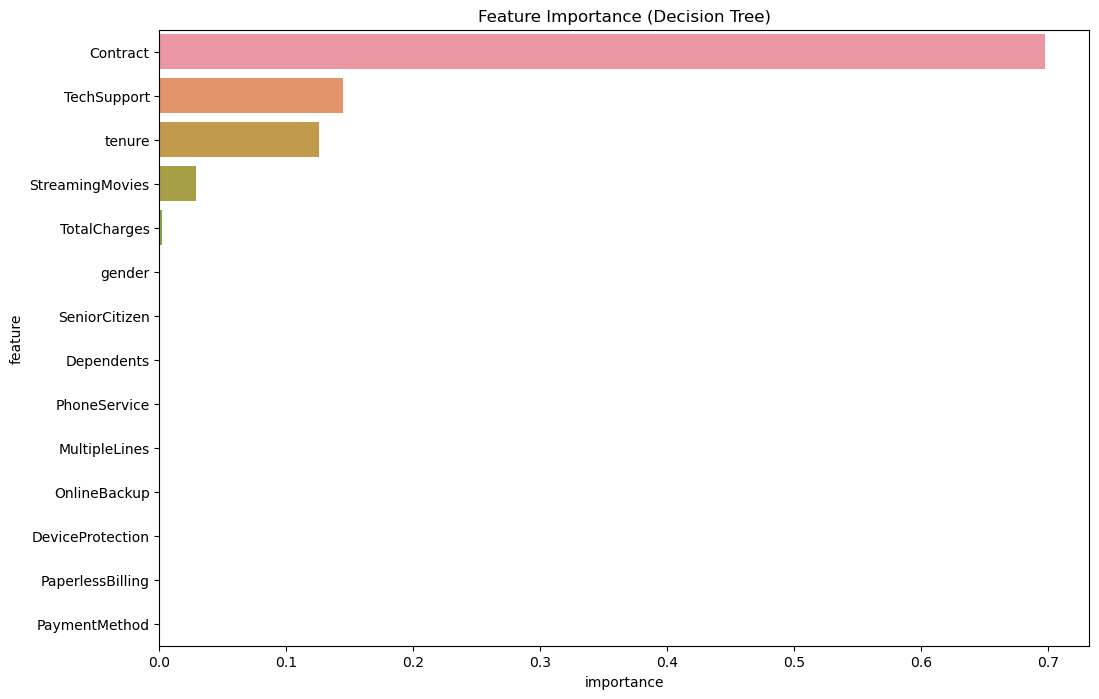

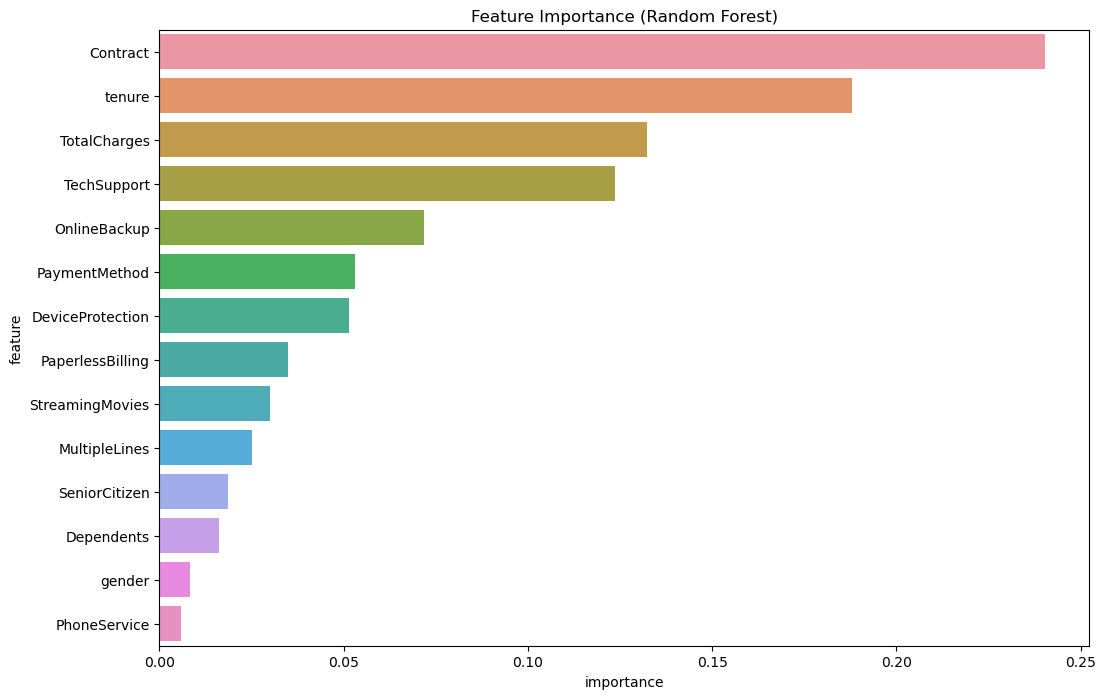

In [43]:
# Decision Tree feature importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': dt_best.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Decision Tree)')
plt.show()

# Random Forest feature importance
plt.figure(figsize=(12, 8))
feature_importance_rf = pd.DataFrame({'feature': X.columns, 'importance': rf_best.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values('importance', ascending=False)
sns.barplot(x='importance', y='feature', data=feature_importance_rf)
plt.title('Feature Importance (Random Forest)')
plt.show()



## x.6 Business Insights

In [44]:
# Identify top churning customer segments
top_churn_features = feature_importance_rf.head(5)['feature'].tolist()
churn_segments = df.groupby(top_churn_features)['Churn'].mean().sort_values(ascending=False).head(10)

print("Top Churning Customer Segments:")
print(churn_segments)

# Calculate potential revenue saved by reducing churn
avg_customer_value = df['TotalCharges'].mean()
current_churn_rate = df['Churn'].mean()
potential_churn_reduction = 0.1  # Assume we can reduce churn by 10%

potential_savings = avg_customer_value * len(df) * current_churn_rate * potential_churn_reduction
print(f"\nPotential Annual Revenue Saved: ${potential_savings:.2f}")


Top Churning Customer Segments:
Contract   tenure     TotalCharges  TechSupport  OnlineBackup
-0.828207   0.840014   1.265520     -0.925262     1.242550       1.0
           -1.073843  -0.786127      1.396299    -1.029919       1.0
                      -0.788467     -0.925262    -1.029919       1.0
           -0.259435   0.030245     -0.925262    -1.029919       1.0
           -1.073843  -0.792043     -0.925262     1.242550       1.0
           -0.259435   0.034660     -0.925262    -1.029919       1.0
                       0.043380     -0.925262     1.242550       1.0
           -1.073843  -0.797297     -0.925262     1.242550       1.0
                      -0.798467     -0.925262    -1.029919       1.0
                      -0.800719     -0.925262    -1.029919       1.0
Name: Churn, dtype: float64

Potential Annual Revenue Saved: $0.00
